# **<u>"Eigenvalue analysis of stochastic structural systems: A quantum computing approach"</u>**



The following jupyter notebook is a demonstration of the second numerical example of the paper **"Eigenvalue analysis of stochastic structural systems: A quantum computing approach"**, in the absence of randomness.


In [1]:
from qiskit import QuantumCircuit
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp
import numpy as np

#Stifness matrix

def trid_matrix(k):
    n = np.size(k,0)
    k_f = np.zeros((n,n))
    k_f[n-1,n-1] = k[-1]
    for i in range(n-1):
        k_f[i,i] = k[i]+k[i+1]
        k_f[i,i+1] = -k[i+1]
        k_f[i+1,i] = -k[i+1]
    return k_f

x = np.ones((4,))
kf = trid_matrix(x)
pauli_op = SparsePauliOp.from_operator(kf)

#2-qubit orthogonal initial states, where the eigenstates will be eventually encoded

input_states = [QuantumCircuit(2), QuantumCircuit(2), QuantumCircuit(2), QuantumCircuit(2)]

input_states[1].x(0)
input_states[2].x(1)
input_states[3].x(0)
input_states[3].x(1)


#hyperparameters

weights = [40,20,10]

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options
from qiskit_ibm_runtime.options import SimulatorOptions, EstimatorOptions
from qiskit_ibm_runtime.fake_provider import FakeBogotaV2

#defining a simulator that mimics the behavior of a quantum processor
backend_fake = FakeBogotaV2()

service = QiskitRuntimeService()
options = Options()
options.resilience_level = 2
options.optimization_level = 1

#Setting appropriate execution options to suppress and mitigate the noise in the quantum computing treatment
sampler_options = Options()
sampler_options.resilience_level = 1
sampler_options.optimization_level = 1

simulator = SimulatorOptions()
options.simulator.seed_simulator = 150

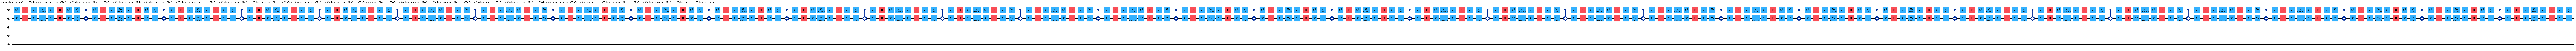

In [3]:
from qiskit.circuit.library import  EfficientSU2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


#2-qubit-ansatz
ansatz_example = EfficientSU2(2, su2_gates = ["ry"], entanglement = 'circular', reps=32)

#Transpilation
passmanager = generate_preset_pass_manager(optimization_level=1, target=backend_fake.target)
isa_circuit = passmanager.run(ansatz_example)
isa_input_state = passmanager.run(input_states)
isa_observable = pauli_op.apply_layout(isa_circuit.layout)


isa_circuit.decompose().draw('mpl', fold = -1)

In [4]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2018, 2022.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# 
# Notice:
#Part of this code has been altered from the originals.

# This implementation is derived from Qiskit's VQE implementation.

#"""The Subspace Search Variational Quantum Eigensolver algorithm.

#See https://arxiv.org/abs/1810.09434.
#"""

from __future__ import annotations

import logging
import warnings
from time import time
from collections.abc import Callable, Sequence

import numpy as np

from qiskit_algorithms.gradients import BaseEstimatorGradient
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import BaseEstimator
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import Statevector

from qiskit_algorithms.exceptions import AlgorithmError
from qiskit_algorithms.list_or_dict import ListOrDict
from qiskit_algorithms.optimizers import Optimizer, Minimizer, OptimizerResult
from qiskit_algorithms.variational_algorithm import (
    VariationalAlgorithm,
    VariationalResult,
)
from qiskit_algorithms.eigensolvers import Eigensolver, EigensolverResult

from qiskit_algorithms.observables_evaluator import estimate_observables

logger = logging.getLogger(__name__)


class SSVQE(VariationalAlgorithm, Eigensolver):
    r"""The Subspace Search Variational Quantum Eigensolver algorithm.
    `SSVQE <https://arxiv.org/abs/1810.09434>`__ is a hybrid quantum-classical
    algorithm that uses a variational technique to find the low-lying eigenvalues
    of the Hamiltonian :math:`H` of a given system. SSVQE can be seen as
    a natural generalization of VQE. Whereas VQE minimizes the expectation
    value of :math:`H` with respect to the ansatz state, SSVQE takes a set
    of mutually orthogonal input states :math:`\{| \psi_{i}} \rangle\}_{i=0}^{k-1}`,
    applies the same parameterized ansatz circuit :math:`U(\vec\theta)` to all of them,
    then minimizes a weighted sum of the expectation values of :math:`H` with respect
    to these states.
    """

    def __init__(
        self,
        estimator: BaseEstimator,
        k: int | None = 2,
        ansatz: QuantumCircuit | None = None,
        optimizer: Optimizer | Minimizer | None = None,
        initial_point: Sequence[float] | None = None,
        initial_states: list[QuantumCircuit] | None = None,
        weight_vector: Sequence[float] | Sequence[int] | None = None,
        gradient: BaseEstimatorGradient | None = None,
        callback: Callable[[int, np.ndarray, Sequence[float], float], None]
        | None = None,
        check_input_states_orthogonality: bool = True,
    ) -> None:
        """
        Args:
            estimator: The estimator primitive.
            k: The number of eigenstates that the algorithm will attempt to find.
            ansatz: A parameterized circuit used as Ansatz for the wave function.
            optimizer: A classical optimizer. Can either be a Qiskit optimizer or a callable
                that takes an array aas input and returns a Qiskit or SciPy optimization result.
            initial_point: An optional initial point (i.e. initial parameter values)
                for the optimizer. If ``None`` then VQE will look to the ansatz for a preferred
                point and if not will simply compute a random one.
            initial_states: An optional list of mutually orthogonal initial states.
                If ``None``, then SSVQE will set these to be a list of mutually orthogonal
                computational basis states.
            weight_vector: An optional list or array of real positive numbers with length
                equal to the value of ``num_states`` to be used in the weighted energy summation
                objective function. This fixes the ordering of the returned eigenstate/eigenvalue
                pairs. If ``None``, then SSVQE will default to [n, n-1, ..., 1] for `k` = n.
            gradient: An optional gradient function or operator for optimizer.
            callback: A callback that can access the intermediate data at each optimization step.
                These data are: the evaluation count, the optimizer ansatz parameters,
                the evaluated mean energies, and the metadata dictionary.
            check_input_states_orthogonality: A boolean that sets whether or not to check
                that the value of ``initial_states`` passed consists of a mutually orthogonal
                set of states. If ``True``, then SSVQE will check that these states are mutually
                orthogonal and return an error if they are not. This is set to ``True`` by default,
                but setting this to ``False`` may be desirable for larger numbers of qubits to avoid
                exponentially large computational overhead before the simulation even starts.
        """

        super().__init__()

        self.k = k
        self.initial_states = initial_states
        self.weight_vector = weight_vector
        self.ansatz = ansatz
        self.optimizer = optimizer
        self.initial_point = initial_point
        self.gradient = gradient
        self.callback = callback
        self.estimator = estimator
        self.check_initial_states_orthogonal = check_input_states_orthogonality

    @property
    def initial_point(self) -> Sequence[float] | None:
        """Returns initial point"""
        return self._initial_point

    @initial_point.setter
    def initial_point(self, initial_point: Sequence[float] | None):
        """Sets initial point"""
        self._initial_point = initial_point

    @classmethod
    def supports_aux_operators(cls) -> bool:
        return True

    def compute_eigenvalues(
        self,
        operator: BaseOperator | SparsePauliOp,
        aux_operators: ListOrDict[BaseOperator | SparsePauliOp] | None = None,
    ) -> EigensolverResult:

        ansatz = self._check_operator_ansatz(operator)

        initial_point = _validate_initial_point(self.initial_point, ansatz)

        initial_states = self.initial_states


        bounds = [(-9000, 9000)] * len(initial_point) #this is for noisy estimators BObYQA, IMFIL


        initialized_ansatz_list = [
            initial_states[n].compose(ansatz) for n in range(self.k)
        ]

        self.weight_vector = self._check_weight_vector(self.weight_vector)

        evaluate_weighted_energy_sum = self._get_evaluate_weighted_energy_sum(
            initialized_ansatz_list, operator
        )

        if self.gradient is not None:  # need to implement _get_evaluate_gradient
            evaluate_gradient = self._get_evalute_gradient(
                initialized_ansatz_list, operator
            )
        else:
            evaluate_gradient = None

        if aux_operators:
            zero_op = SparsePauliOp.from_list([("I" * self.ansatz.num_qubits, 0)])

            if isinstance(aux_operators, list):
                key_op_iterator = enumerate(aux_operators)
                converted = [zero_op] * len(aux_operators)
            else:
                key_op_iterator = aux_operators.items()
                converted = {}
            for key, op in key_op_iterator:
                if op is not None:
                    converted[key] = zero_op if op == 0 else op

            aux_operators = converted

        else:
            aux_operators = None

        start_time = time()

        if callable(self.optimizer):
            optimizer_result = self.optimizer(
                fun=evaluate_weighted_energy_sum,
                x0=initial_point,
                jac=evaluate_gradient,
                bounds=bounds,
            )
        else:
            optimizer_result = self.optimizer.minimize(
                fun=evaluate_weighted_energy_sum,
                x0=initial_point,
                jac=evaluate_gradient,
                bounds=bounds,
            )

        optimizer_time = time() - start_time

        logger.info(
            "Optimization complete in %s seconds.\nFound opt_params %s",
            optimizer_time,
            optimizer_result.x,
        )

        if aux_operators is not None:
            bound_ansatz_list = [
                initialized_ansatz_list[n].bind_parameters(optimizer_result.x)
                for n in range(self.k)
            ]

            aux_values_list = [
                estimate_observables(
                    self.estimator,
                    bound_ansatz_list[n],
                    aux_operators,
                )
                for n in range(self.k)
            ]
        else:
            aux_values_list = None

        return self._build_ssvqe_result(
            optimizer_result,
            aux_values_list,
            optimizer_time,
            operator,
            initialized_ansatz_list,
        )

    def _get_evaluate_weighted_energy_sum(
        self,
        initialized_ansatz_list: list[QuantumCircuit],
        operator: BaseOperator | SparsePauliOp,
    ) -> tuple[Callable[[np.ndarray], float | list[float]], dict]:
        """Returns a function handle to evaluate the weighted energy sum at given parameters
        for the ansatz. This is the objective function to be passed to the optimizer
        that is used for evaluation.
        Args:
            initialized_anastz_list: A list consisting of copies of the ansatz initialized
                in the initial states.
            operator: The operator whose expectation value with respect to each of the
                states in ``initialzed_ansatz_list`` is being measured.
        Returns:
            Weighted expectation value sum of the operator for each parameter.
        Raises:
            AlgorithmError: If the primitive job to evaluate the weighted energy
                sum fails.
        """
        num_parameters = initialized_ansatz_list[0].num_parameters

        eval_count = 0

        def evaluate_weighted_energy_sum(parameters):
            nonlocal eval_count
            parameters = np.reshape(parameters, (-1, num_parameters)).tolist()
            batchsize = len(parameters)

            try:
                job = self.estimator.run(
                    [
                        initialized_ansatz_list[m]
                        for n in range(batchsize)
                        for m in range(self.k)
                    ],
                    [operator] * self.k * batchsize,
                    [parameters[n] for n in range(batchsize) for m in range(self.k)],
                )
                result = job.result()
                values = result.values

                energies = np.reshape(values, (batchsize, self.k))
                weighted_energy_sums = np.dot(energies, self.weight_vector).tolist()
                energies = energies.tolist()

            except Exception as exc:
                raise AlgorithmError(
                    "The primitive job to evaluate the energy failed!"
                ) from exc

            if self.callback is not None:
                metadata = result.metadata
                for params, energies_value, metadata in zip(
                    parameters, energies, metadata
                ):
                    eval_count += 1
                    self.callback(eval_count, params, energies_value, metadata)

            return (
                weighted_energy_sums[0]
                if len(weighted_energy_sums) == 1
                else weighted_energy_sums
            )

        return evaluate_weighted_energy_sum

    def _get_evalute_gradient(
        self,
        initialized_ansatz_list: list[QuantumCircuit],
        operator: BaseOperator | SparsePauliOp,
    ) -> tuple[Callable[[np.ndarray], np.ndarray]]:
        """Get a function handle to evaluate the gradient at given parameters for the ansatz.
        Args:
            initialized_ansatz_list: The list of initialized ansatz preparing the quantum states.
            operator: The operator whose energy to evaluate.
        Returns:
            A function handle to evaluate the gradient at given parameters for the initialized
            ansatz list.
        Raises:
            AlgorithmError: If the primitive job to evaluate the gradient fails.
        """

        def evaluate_gradient(parameters):
            try:
                job = self.gradient.run(
                    initialized_ansatz_list,
                    [operator] * self.k,
                    [parameters for n in range(self.k)],
                )
                energy_gradients = job.result().gradients
                weighted_energy_sum_gradient = sum(
                    [self.weight_vector[n] * energy_gradients[n] for n in range(self.k)]
                )
            except Exception as exc:
                raise AlgorithmError(
                    "The primitive job to evaluate the gradient failed!"
                ) from exc

            return weighted_energy_sum_gradient

        return evaluate_gradient

    def _check_circuit_num_qubits(
        self,
        operator: BaseOperator | SparsePauliOp,
        circuit: QuantumCircuit,
        circuit_type: str,
    ) -> QuantumCircuit:
        """Check that the number of qubits for the circuit passed matches
        the number of qubits  of the operator.
        """
        if operator.num_qubits != circuit.num_qubits:
            try:
                logger.info(
                    "Trying to resize %s to match operator on %s qubits.",
                    circuit_type,
                    operator.num_qubits,
                )
                circuit.num_qubits = operator.num_qubits
            except AttributeError as error:
                raise AlgorithmError(
                    f"The number of qubits of the {circuit_type} does not match the ",
                    f"operator, and the {circuit_type} does not allow setting the "
                    "number of qubits using `num_qubits`.",
                ) from error
        return circuit

    def _check_operator_ansatz(
        self, operator: BaseOperator | SparsePauliOp
    ) -> QuantumCircuit:
        """Check that the number of qubits of operator and ansatz match and that the ansatz is
        parameterized.
        """
        # set defaults
        if self.ansatz is None:
            ansatz = RealAmplitudes(num_qubits=operator.num_qubits, reps=6)
        else:
            ansatz = self.ansatz

        ansatz = self._check_circuit_num_qubits(
            operator=operator, circuit=ansatz, circuit_type="ansatz"
        )

        if ansatz.num_parameters == 0:
            raise AlgorithmError(
                "The ansatz must be parameterized, but has no free parameters."
            )

        return ansatz

    def _check_operator_initial_states(
        self,
        list_of_states: list[QuantumCircuit] | None,
        operator: BaseOperator | SparsePauliOp,
    ) -> QuantumCircuit:

        """Check that the number of qubits of operator and all the initial states match."""

        if list_of_states is None:
            initial_states = [
                QuantumCircuit(operator.num_qubits) for n in range(self.k)
            ]


        else:
            initial_states = list_of_states
            if self.check_initial_states_orthogonal is True:
                stacked_states_array = np.hstack(
                    [np.asarray(Statevector(state)) for state in initial_states]
                )


        for initial_state in initial_states:
            initial_state = self._check_circuit_num_qubits(
                operator=operator, circuit=initial_state, circuit_type="initial state"
            )

        return initial_states

    def _check_weight_vector(self, weight_vector: Sequence[float]) -> Sequence[float]:
        """Check that the number of weights matches the number of states."""
        if weight_vector is None:
            weight_vector = [self.k - n for n in range(self.k)]
        elif len(weight_vector) != self.k:
            raise AlgorithmError(
                "The number of weights provided does not match the number of states."
            )

        return weight_vector

    def _eval_aux_ops(
        self,
        ansatz: QuantumCircuit,
        aux_operators: ListOrDict[BaseOperator | SparsePauliOp],
    ) -> ListOrDict[tuple(complex, complex)]:
        """Compute auxiliary operator eigenvalues."""

        if isinstance(aux_operators, dict):
            aux_ops = list(aux_operators.values())
        else:
            aux_ops = aux_operators

        num_aux_ops = len(aux_ops)

        try:
            aux_job = self.estimator.run([ansatz] * num_aux_ops, aux_ops)
            aux_values = aux_job.result().values
            aux_values = list(zip(aux_values, [0] * len(aux_values)))

            if isinstance(aux_operators, dict):
                aux_values = dict(zip(aux_operators.keys(), aux_values))

        except Exception as exc:
            raise AlgorithmError(
                "The primitive job to evaluate the aux operator values failed!"
            ) from exc

        return aux_values

    def _build_ssvqe_result(
        self,
        optimizer_result: OptimizerResult,
        aux_operators_evaluated: ListOrDict[tuple[complex, tuple[complex, int]]],
        optimizer_time: float,
        operator: BaseOperator | SparsePauliOp,
        initialized_ansatz_list: list[QuantumCircuit],
    ) -> SSVQEResult:
        result = SSVQEResult()

        try:
            result.eigenvalues = (
                self.estimator.run(
                    initialized_ansatz_list,
                    [operator] * self.k,
                    [optimizer_result.x] * self.k,
                )
                .result()
                .values
            )

        except Exception as exc:
            raise AlgorithmError(
                "The primitive job to evaluate the eigenvalues failed!"
            ) from exc

        result.cost_function_evals = optimizer_result.nfev
        result.optimal_point = optimizer_result.x
        result.optimal_parameters = dict(
            zip(self.ansatz.parameters, optimizer_result.x)
        )
        result.optimal_value = optimizer_result.fun
        result.optimizer_time = optimizer_time
        result.aux_operators_evaluated = aux_operators_evaluated
        result.optimizer_result = optimizer_result

        return result


class SSVQEResult(VariationalResult, EigensolverResult):
    """SSVQE Result."""

    def __init__(self) -> None:
        super().__init__()
        self._cost_function_evals = None

    @property
    def cost_function_evals(self) -> int:
        """Returns number of cost optimizer evaluations"""
        return self._cost_function_evals

    @cost_function_evals.setter
    def cost_function_evals(self, value: int) -> None:
        """Sets number of cost function evaluations"""
        self._cost_function_evals = value


def _validate_initial_point(point, ansatz):
    expected_size = ansatz.num_parameters

    if point is None and hasattr(ansatz, "preferred_init_points"):
        point = ansatz.preferred_init_points

    if point is None:
        bounds = getattr(ansatz, "parameter_bounds", None)
        if bounds is None:
            bounds = [(-2 * np.pi, 2 * np.pi)] * expected_size

        lower_bounds = []
        upper_bounds = []
        for lower, upper in bounds:
            lower_bounds.append(lower if lower is not None else -2 * np.pi)
            upper_bounds.append(upper if upper is not None else 2 * np.pi)

        point = algorithm_globals.random.uniform(lower_bounds, upper_bounds)

    elif len(point) != expected_size:
        raise ValueError(
            f"The dimension of the initial point ({len(point)}) does not match the "
            f"number of parameters in the circuit ({expected_size})."
        )

    return point


def _validate_bounds(ansatz):
    if hasattr(ansatz, "parameter_bounds") and ansatz.parameter_bounds is not None:
        bounds = ansatz.parameter_bounds
        if len(bounds) != ansatz.num_parameters:
            raise ValueError(
                f"The number of bounds ({len(bounds)}) does not match the number of "
                f"parameters in the circuit ({ansatz.num_parameters})."
            )
    else:
        bounds = [(None, None)] * ansatz.num_parameters

    return bounds

In [5]:
#initial point of the optimization
x0 = np.zeros((66))

estimator = Estimator(options=options, backend=backend_fake)

#algorithm execution, k equals the number of equivalues to be determined
ssvqe_instance = SSVQE(k=3, weight_vector = weights, estimator=estimator, initial_point=x0,
                                optimizer=COBYLA(maxiter=450),
                                ansatz=isa_circuit, initial_states = isa_input_state
                                )
    
    
result = ssvqe_instance.compute_eigenvalues(isa_observable)
result_real_kf = np.linalg.eigvals(kf)

In [6]:
ssvqe_eigenvalues = result.eigenvalues
ssvqe_eigenvalues_sorted = np.sort(ssvqe_eigenvalues)
result_real_kf_sorted = np.sort(result_real_kf)

for i in range(len(result_real_kf_sorted)-1):
    print(f"Eigenvalue {i+1} SSVQE : {ssvqe_eigenvalues_sorted[i]:.3f}")
    
print()

for i in range(len(result_real_kf)-1):
    print(f"Eigenvalue {i+1} : {result_real_kf_sorted[i]:.3f}")

Eigenvalue 1 SSVQE : 0.137
Eigenvalue 2 SSVQE : 0.976
Eigenvalue 3 SSVQE : 2.340

Eigenvalue 1 : 0.121
Eigenvalue 2 : 1.000
Eigenvalue 3 : 2.347
